#### 폰트 설정 및 라이브러리 설치 

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
%matplotlib inline
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


# 서울시 상권분석 서비스에서 전처리 한 최종 데이터 파일 last.csv 파일 불러오기
# 군집화 완료한 cluster1부터 cluster5까지 불러오기

In [3]:
data = pd.read_csv('last.csv')
data.drop(columns='점포수', inplace=True)

cluster1 = pd.read_csv('cluster1.csv')
cluster2 = pd.read_csv('cluster2.csv')
cluster3 = pd.read_csv('cluster3.csv')
cluster4 = pd.read_csv('cluster4.csv')
cluster5 = pd.read_csv('cluster5.csv')

# 모델링에 사용할 데이터 전처리

In [4]:
# 교통시설 관련 열들을 합하여 '교통시설_수' 열을 생성
data['교통시설_수'] = data['지하철_역_수'] + data['버스_정거장_수'] + data['공항_수'] + data['철도_역_수'] + data['버스_터미널_수']

# 학교 관련 열들을 합하여 '학교_수' 열을 생성
data['학교_수'] = data['유치원_수'] + data['초등학교_수'] + data['중학교_수'] + data['고등학교_수'] + data['대학교_수']

# 기타 집객시설 관련 열들을 활용하여 '기타_집객시설_수' 열을 생성
data['기타_집객시설_수'] = data['집객시설_수'] - data['지하철_역_수'] - data['버스_정거장_수'] - data['공항_수'] - data['철도_역_수'] - data['버스_터미널_수'] - data['초등학교_수'] - data['중학교_수'] - data['고등학교_수'] - data['대학교_수']

# 삭제할 열 이름들을 리스트에 저장
drop_columns = ['지하철_역_수','버스_정거장_수','공항_수','철도_역_수','버스_터미널_수','집객시설_수'
 ,'관공서_수', '은행_수', '종합병원_수', '일반_병원_수', '약국_수','유치원_수', '초등학교_수', '중학교_수', '고등학교_수','대학교_수', '백화점_수', '슈퍼마켓_수', '극장_수', '숙박_시설_수']

# 위에서 지정한 열들을 데이터프레임에서 삭제
data = data.drop(columns=drop_columns)


In [5]:
# '상주인구'가 열 이름에 포함된 열들을 'resident_columns' 리스트에 저장
resident_columns = [col for col in data.columns if '상주인구' in col]

# '생활인구'가 열 이름에 포함된 열들을 'living_columns' 리스트에 저장
living_columns = [col for col in data.columns if '생활인구' in col]

# '직장_인구'가 열 이름에 포함된 열들을 'work_columns' 리스트에 저장
work_columns = [col for col in data.columns if '직장_인구' in col]


In [6]:
# 필요없는 직장 인구 관련 열들을 삭제
data.drop(columns=['총_직장_인구_수', '남성_직장_인구_수', '여성_직장_인구_수'], inplace=True)

# 필요없는 생활 인구 관련 열들을 삭제
data.drop(columns=['총_생활인구_수', '남성_생활인구_수', '여성_생활인구_수'], inplace=True)

# 필요없는 상주 인구 관련 열들을 삭제
data.drop(columns=['총_상주인구_수', '남성_상주인구_수', '여성_상주인구_수'], inplace=True)


In [7]:
# 비경제활동가능 상주인구와 경제활동가능 상주인구를 계산하고 열을 추가
non_economic_resident_columns = ['연령대_10_상주인구_수', '연령대_60_이상_상주인구_수']
economic_resident_columns = [
    '연령대_20_상주인구_수',
    '연령대_30_상주인구_수',
    '연령대_40_상주인구_수',
    '연령대_50_상주인구_수'
]
data['비경제활동가능_상주인구_수'] = data[non_economic_resident_columns].sum(axis=1)
data['경제활동가능_상주인구_수'] = data[economic_resident_columns].sum(axis=1)

# 비경제활동가능 생활인구와 경제활동가능 생활인구를 계산하고 열을 추가
non_economic_living_columns = ['연령대_10_생활인구_수', '연령대_60_이상_생활인구_수']
economic_living_columns = [
    '연령대_20_생활인구_수',
    '연령대_30_생활인구_수',
    '연령대_40_생활인구_수',
    '연령대_50_생활인구_수'
]
data['비경제활동가능_생활인구_수'] = data[non_economic_living_columns].sum(axis=1)
data['경제활동가능_생활인구_수'] = data[economic_living_columns].sum(axis=1)

# 비경제활동가능 직장인구와 경제활동가능 직장인구를 계산하고 열을 추가
non_economic_work_columns = ['연령대_10_직장_인구_수', '연령대_60_이상_직장_인구_수']
economic_work_columns = [
    '연령대_20_직장_인구_수',
    '연령대_30_직장_인구_수',
    '연령대_40_직장_인구_수',
    '연령대_50_직장_인구_수'
]
data['비경제활동가능_직장인구_수'] = data[non_economic_work_columns].sum(axis=1)
data['경제활동가능_직장인구_수'] = data[economic_work_columns].sum(axis=1)

# 불필요한 열들을 제거
data = data.drop(
    non_economic_resident_columns + economic_resident_columns +
    non_economic_living_columns + economic_living_columns +
    non_economic_work_columns + economic_work_columns,
    axis=1
)

# '_amount' 또는 '_prob'가 열 이름에 포함된 열들을 제거
columns_to_drop = [
    col for col in data.columns if '_amount' in col or '_prob' in col 
]
data = data.drop(columns=columns_to_drop)

# 결과 데이터프레임을 출력
data.head()


,상권_코드,월_평균_소득_금액,소득_구간_코드,운영_영업_개월_평균,폐업_영업_개월_평균,서울_운영_영업_개월_평균,서울_폐업_영업_개월_평균,남성연령대_10_상주인구_수,남성연령대_20_상주인구_수,남성연령대_30_상주인구_수,...,연령대_60_이상_매출_건수,교통시설_수,학교_수,기타_집객시설_수,비경제활동가능_상주인구_수,경제활동가능_상주인구_수,비경제활동가능_생활인구_수,경제활동가능_생활인구_수,비경제활동가능_직장인구_수,경제활동가능_직장인구_수
0,2110001,4.453866e+06,8.0625,98.5000,61.4375,110.1875,53.5625,105.0000,81.1250,51.125,...,1403.714062,4.5625,0.0000,4.6875,469.1250,652.2500,80360.2500,88775.5625,108.0625,710.0625
1,2110002,3.363814e+06,7.0000,131.3750,60.9375,110.1875,53.5625,41.8125,25.1250,29.125,...,5148.741909,4.0000,0.0000,14.6875,343.3750,293.8125,144041.1875,162034.3125,34.9375,484.1250
2,2110003,3.540374e+06,7.0000,115.5625,57.8750,110.1875,53.5625,279.0625,244.8750,185.125,...,831.389037,6.2500,0.0000,9.4375,1286.5625,1931.5000,156999.1875,185129.0000,61.8125,350.1250
3,2110004,2.658326e+06,6.0000,155.1250,77.8125,110.1875,53.5625,32.7500,31.1250,27.750,...,716.296848,2.0000,0.0000,3.9375,217.6875,260.6875,157910.3125,193380.0625,4.1250,31.3125
4,2110005,3.696801e+06,7.1875,117.2500,58.1875,110.1875,53.5625,160.3125,119.5625,98.375,...,676.489609,5.3125,0.6875,12.4375,749.9375,1059.3125,95487.1250,125486.5625,92.1875,739.2500


In [8]:
# '상권_코드'가 cluster1의 '상권_코드'에 속하면 'cluster' 열에 'cluster1' 값 할당
data.loc[data['상권_코드'].isin(cluster1['상권_코드']), 'cluster'] = 'cluster1'

# '상권_코드'가 cluster2의 '상권_코드'에 속하면 'cluster' 열에 'cluster2' 값 할당
data.loc[data['상권_코드'].isin(cluster2['상권_코드']), 'cluster'] = 'cluster2'

# '상권_코드'가 cluster3의 '상권_코드'에 속하면 'cluster' 열에 'cluster3' 값 할당
data.loc[data['상권_코드'].isin(cluster3['상권_코드']), 'cluster'] = 'cluster3'

# '상권_코드'가 cluster4의 '상권_코드'에 속하면 'cluster' 열에 'cluster4' 값 할당
data.loc[data['상권_코드'].isin(cluster4['상권_코드']), 'cluster'] = 'cluster4'

# '상권_코드'가 cluster5의 '상권_코드'에 속하면 'cluster' 열에 'cluster5' 값 할당
data.loc[data['상권_코드'].isin(cluster5['상권_코드']), 'cluster'] = 'cluster5'

# 'cluster' 열을 출력
data['cluster']


0       cluster4
1       cluster5
2       cluster3
3       cluster4
4       cluster3
          ...   
1055    cluster3
1056    cluster2
1057    cluster5
1058    cluster5
1059    cluster5
Name: cluster, Length: 1060, dtype: object

In [9]:
# 분기당_매출_금액이 1e+09 이상인 상권_코드 제외하고 학습
data = data[data['상권_코드'] != 2110065]
data = data[data['상권_코드'] != 2110164]
data = data[data['상권_코드'] != 2110116]
data = data[data['상권_코드'] != 2110788]
data = data[data['상권_코드'] != 2110131]
data = data[data['상권_코드'] != 2110137]

In [10]:
# 'cluster' 열을 데이터프레임에서 제거
data.drop(columns='cluster', inplace=True)


In [11]:
# cluster1에 해당하는 '상권_코드'를 가진 행들로 새로운 데이터프레임 data1을 생성
data1 = data[data['상권_코드'].isin(cluster1['상권_코드'])]

# cluster2에 해당하는 '상권_코드'를 가진 행들로 새로운 데이터프레임 data2를 생성
data2 = data[data['상권_코드'].isin(cluster2['상권_코드'])]

# cluster3에 해당하는 '상권_코드'를 가진 행들로 새로운 데이터프레임 data3을 생성
data3 = data[data['상권_코드'].isin(cluster3['상권_코드'])]

# cluster4에 해당하는 '상권_코드'를 가진 행들로 새로운 데이터프레임 data4를 생성
data4 = data[data['상권_코드'].isin(cluster4['상권_코드'])]

# cluster5에 해당하는 '상권_코드'를 가진 행들로 새로운 데이터프레임 data5를 생성
data5 = data[data['상권_코드'].isin(cluster5['상권_코드'])]

# data1, data2, data3, data4, data5에서 '상권_코드' 열을 제거
data1.drop(columns=['상권_코드'], inplace=True)
data2.drop(columns=['상권_코드'], inplace=True)
data3.drop(columns=['상권_코드'], inplace=True)
data4.drop(columns=['상권_코드'], inplace=True)
data5.drop(columns=['상권_코드'], inplace=True)


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_29555/1762938111.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1.drop(columns=['상권_코드'], inplace=True)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_29555/1762938111.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2.drop(columns=['상권_코드'], inplace=True)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_29555/1762938111.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

In [12]:
import numpy as np

# 데이터프레임 리스트 생성
dataframes = [data1, data2, data3, data4, data5]

percentiles = [0.33, 0.66]
#percentiles = [0.2, 0.4, 0.6, 0.8]
#percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

results = []

# 각 percentile 별로 처리
for percentile in percentiles:
    percentile_values = []
    
    # 각 데이터프레임 별로 처리
    for df in dataframes:
        percentile_value = df['주중_매출_금액'].quantile(percentile)
        percentile_values.append(percentile_value)
    
    # 해당 percentile에서의 평균 계산
    avg_value = np.mean(percentile_values)
    results.append(avg_value)

# 결과 출력
for idx, percentile in enumerate(percentiles):
    print(f"{percentile:.1f} percentile 평균 값: {results[idx]}")

results = [0] + results + [float('inf')]

# 각 데이터프레임 별로 처리
for df in dataframes:
    df['주중_매출_범주'] = pd.cut(df['주중_매출_금액'], bins=results, labels=range(0,3), right=False)

# 결과 출력 (data1을 예시로 출력)
print(data1[ '주중_매출_범주'].unique().sort_values())
print(data2[ '주중_매출_범주'].unique().sort_values())
print(data3[ '주중_매출_범주'].unique().sort_values())
print(data4[ '주중_매출_범주'].unique().sort_values())
print(data5[ '주중_매출_범주'].unique().sort_values())

0.3 percentile 평균 값: 113489220.69375376
0.7 percentile 평균 값: 187524178.17735228
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]
[0, 1, 2]
Categories (3, int64): [0 < 1 < 2]


/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_29555/3790753536.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주중_매출_범주'] = pd.cut(df['주중_매출_금액'], bins=results, labels=range(0,3), right=False)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_29555/3790753536.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['주중_매출_범주'] = pd.cut(df['주중_매출_금액'], bins=results, labels=range(0,3), right=False)
/var/folders/zn/z7q7zstd5jg_tg51vl5zplj80000gn/T/ipykernel_29555/3790753536.py:33:

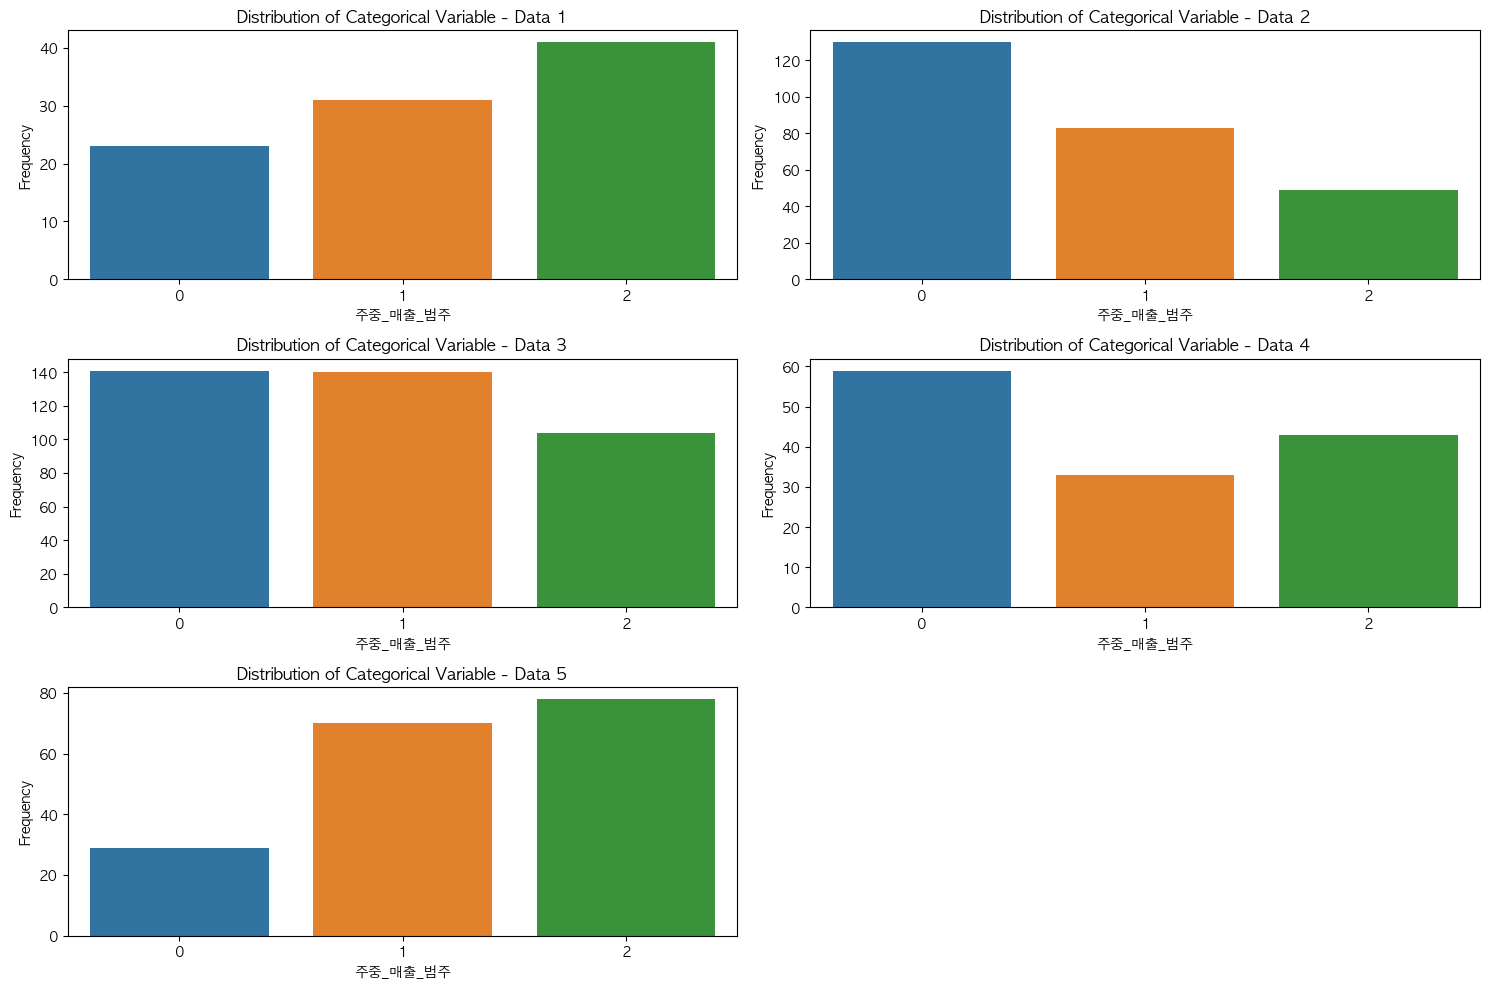

In [13]:
# 데이터 프레임 리스트 생성
dataframes = [data1, data2, data3, data4, data5]
num_rows = 3
num_cols = 2

# 그래프 그리기
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

for idx, df in enumerate(dataframes):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]
    
    category_counts = df['주중_매출_범주'].value_counts()
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)
    ax.set_title(f"Distribution of Categorical Variable - Data {idx+1}")
    ax.set_xlabel("주중_매출_범주")
    ax.set_ylabel("Frequency")

# 빈 서브플롯 제거
for idx in range(len(dataframes), num_rows*num_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.show()


# Cluster1 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

Index(['주중_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주말_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수',
       '비경제활동가능_상주인구_수', '경제활동가능_상주인구_수', '비경제활동가능_직장인구_수', '경제활동가능_직장인구_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50

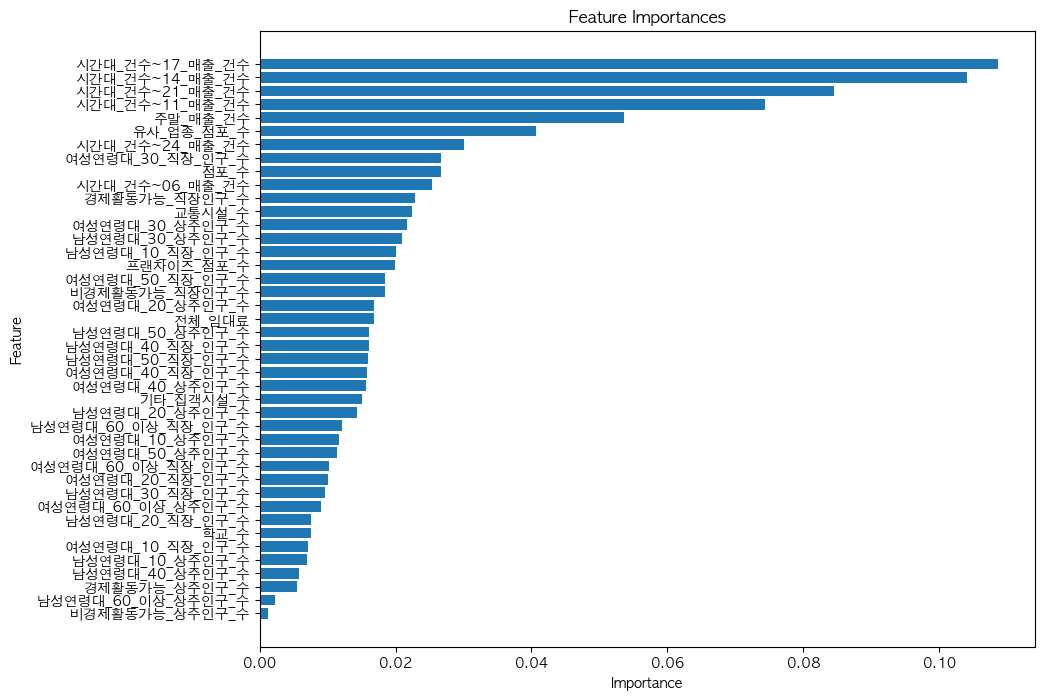

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주중_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주중_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주중_매출_범주': data1_drop['주중_매출_범주'].tolist()})
data1_drop.drop(columns=['주중_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주중_매출_범주']), 
                                                    data_scaled_df['주중_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),  
    'max_features': ['sqrt', 'log2'], 
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # 평가 지표 설정
    cv=5  # 교차 검증 폴드 수
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 뽑아내기
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # y 축 순서를 뒤집습니다 (상위가 위로 올라오게)
plt.show()

# Cluster2 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [15]:
data1 = data2

Index(['주중_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주말_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수',
       '비경제활동가능_상주인구_수', '경제활동가능_상주인구_수', '비경제활동가능_직장인구_수', '경제활동가능_직장인구_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10

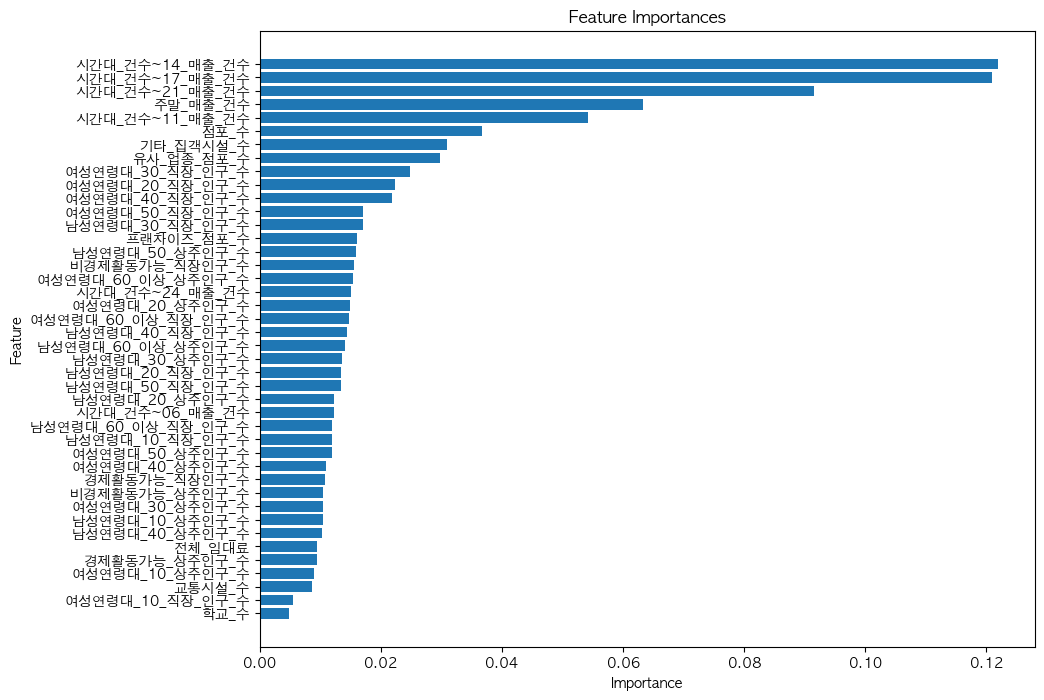

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주중_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주중_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주중_매출_범주': data1_drop['주중_매출_범주'].tolist()})
data1_drop.drop(columns=['주중_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주중_매출_범주']), 
                                                    data_scaled_df['주중_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),  
    'max_features': ['sqrt', 'log2'], 
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # 평가 지표 설정
    cv=5  # 교차 검증 폴드 수
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 뽑아내기
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # y 축 순서를 뒤집습니다 (상위가 위로 올라오게)
plt.show()

# Cluster3 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [17]:
data1 = data3

Index(['주중_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주말_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수',
       '비경제활동가능_상주인구_수', '경제활동가능_상주인구_수', '비경제활동가능_직장인구_수', '경제활동가능_직장인구_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5

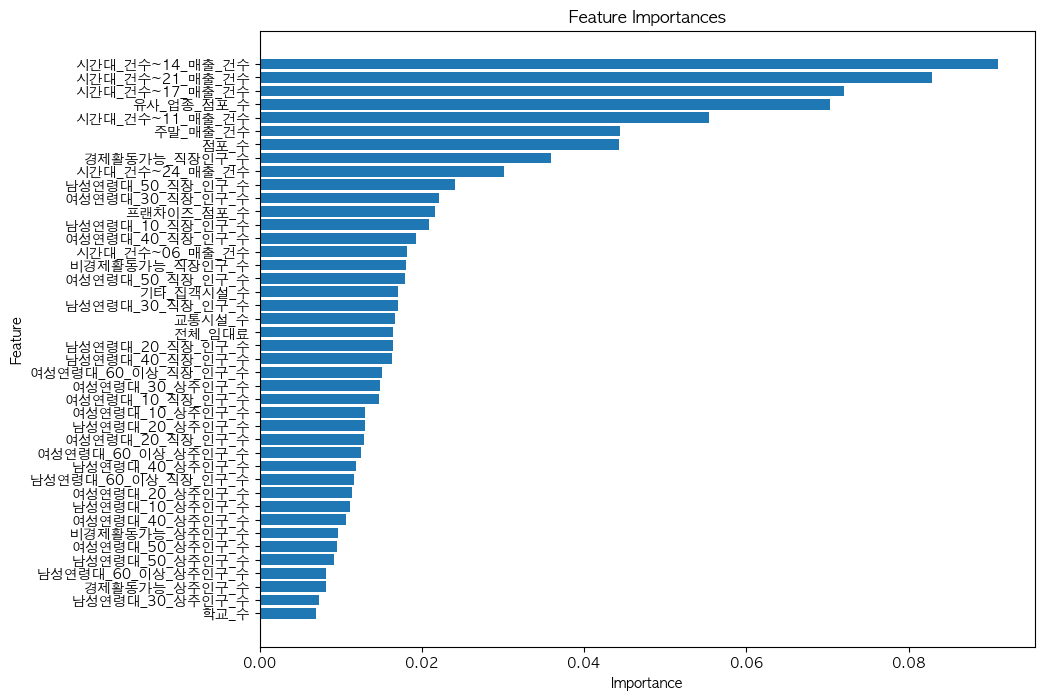

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주중_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주중_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주중_매출_범주': data1_drop['주중_매출_범주'].tolist()})
data1_drop.drop(columns=['주중_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주중_매출_범주']), 
                                                    data_scaled_df['주중_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),  
    'max_features': ['sqrt', 'log2'], 
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # 평가 지표 설정
    cv=5  # 교차 검증 폴드 수
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 뽑아내기
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # y 축 순서를 뒤집습니다 (상위가 위로 올라오게)
plt.show()

# Cluster4 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [19]:
data1 = data4

Index(['주중_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주말_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수',
       '비경제활동가능_상주인구_수', '경제활동가능_상주인구_수', '비경제활동가능_직장인구_수', '경제활동가능_직장인구_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10

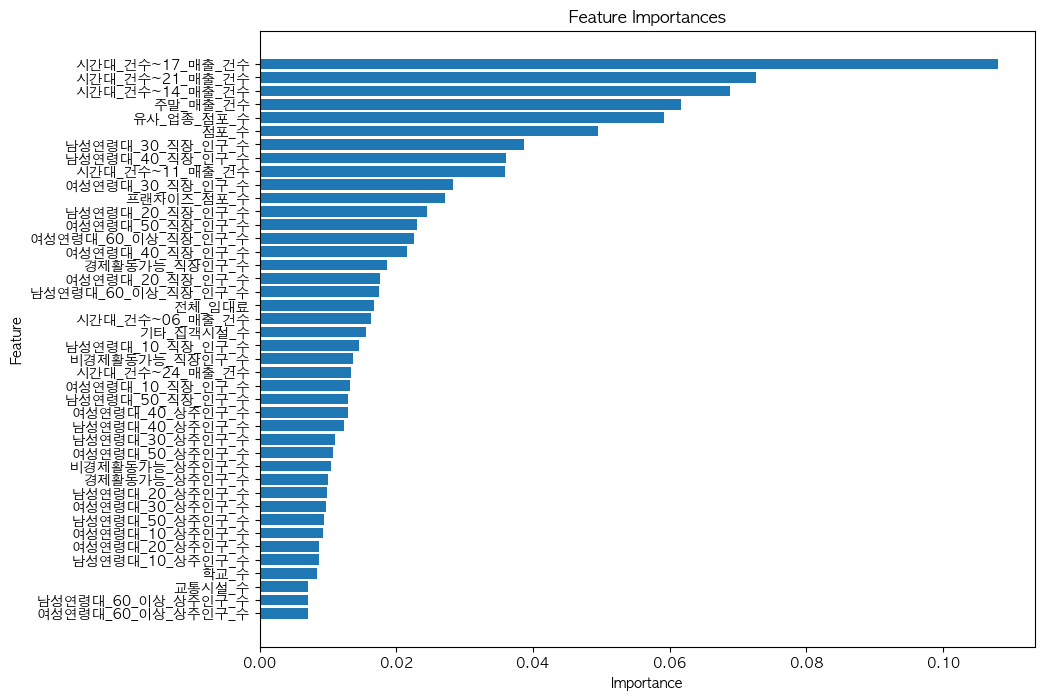

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주중_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주중_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주중_매출_범주': data1_drop['주중_매출_범주'].tolist()})
data1_drop.drop(columns=['주중_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주중_매출_범주']), 
                                                    data_scaled_df['주중_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),  
    'max_features': ['sqrt', 'log2'], 
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # 평가 지표 설정
    cv=5  # 교차 검증 폴드 수
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 뽑아내기
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # y 축 순서를 뒤집습니다 (상위가 위로 올라오게)
plt.show()

# Cluster5 랜덤포레스트(그리드 서치를 통한 하이퍼 파라미터 조정)

#### n_estimators: 랜덤 포레스트에서 생성할 트리의 개수
#### max_depth: 랜덤 포레스트의 개별 트리의 최대 깊이
#### max_features: 각각의 트리가 선택할 수 있는 최대 특성의 개수
#### min_samples_split: 노드를 분할하기 위한 최소한의 샘플 개수
#### min_samples_leaf: 말단 노드(리프 노드)가 가져야 할 최소한의 샘플 개수

In [21]:
data1 = data5

Index(['주중_매출_범주', '남성연령대_10_상주인구_수', '남성연령대_20_상주인구_수', '남성연령대_30_상주인구_수',
       '남성연령대_40_상주인구_수', '남성연령대_50_상주인구_수', '남성연령대_60_이상_상주인구_수',
       '여성연령대_10_상주인구_수', '여성연령대_20_상주인구_수', '여성연령대_30_상주인구_수',
       '여성연령대_40_상주인구_수', '여성연령대_50_상주인구_수', '여성연령대_60_이상_상주인구_수',
       '남성연령대_10_직장_인구_수', '남성연령대_20_직장_인구_수', '남성연령대_30_직장_인구_수',
       '남성연령대_40_직장_인구_수', '남성연령대_50_직장_인구_수', '남성연령대_60_이상_직장_인구_수',
       '여성연령대_10_직장_인구_수', '여성연령대_20_직장_인구_수', '여성연령대_30_직장_인구_수',
       '여성연령대_40_직장_인구_수', '여성연령대_50_직장_인구_수', '여성연령대_60_이상_직장_인구_수', '전체_임대료',
       '점포_수', '유사_업종_점포_수', '프랜차이즈_점포_수', '주말_매출_건수', '시간대_건수~06_매출_건수',
       '시간대_건수~11_매출_건수', '시간대_건수~14_매출_건수', '시간대_건수~17_매출_건수',
       '시간대_건수~21_매출_건수', '시간대_건수~24_매출_건수', '교통시설_수', '학교_수', '기타_집객시설_수',
       '비경제활동가능_상주인구_수', '경제활동가능_상주인구_수', '비경제활동가능_직장인구_수', '경제활동가능_직장인구_수'],
      dtype='object')
Best Hyperparameters: {'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50

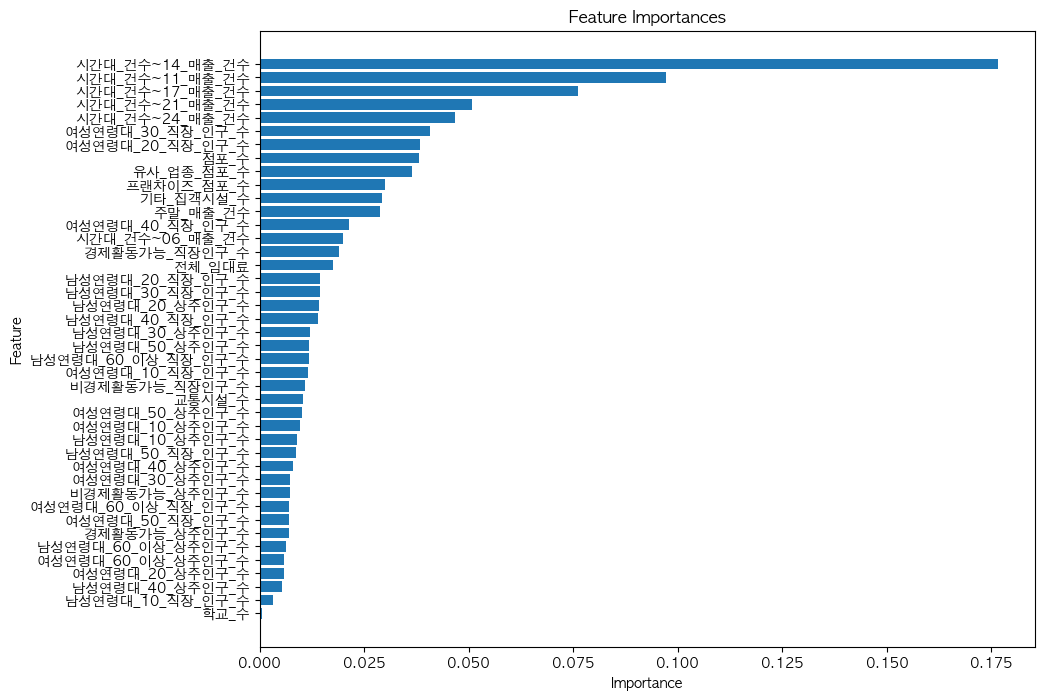

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# '매출_건수' in col 조절하자
num_classes = 3

# Filter columns to drop
columns_to_drop = [
    col for col in data1.columns
    if '1층' in col or '분기당_매출_건수' in col or '율' in col or '0_매출_건수' in col or '이상_매출_건수' in col or '소득_구간_코드' in col or '평균' in col or '폐업' in col or '개업' in col or '주중_매출_건수' in col or '남성_매출_건수' in col or '여성_매출_건수' in col or '생활' in col or '가구' in col or '서울' in col or '0_매출_건수' in col or '요일' in col or '매출_비율' in col or '매출_금액' in col 
    if col != '주중_매출_범주' 
]

# Drop the selected columns from the DataFrame
data1_drop = data1.drop(columns=columns_to_drop)

# Separate the '주중_매출_범주' column
# 주중_매출_범주 데이터 리스트로 생성한 후 DataFrame 생성
code = pd.DataFrame({'주중_매출_범주': data1_drop['주중_매출_범주'].tolist()})
data1_drop.drop(columns=['주중_매출_범주'], inplace=True)

# Min-Max 스케일링
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data1_drop)

# Convert scaled data to a DataFrame
data_scaled_df = pd.DataFrame(data_scaled, columns=data1_drop.columns)

# Combine scaled data with '주중_매출_범주'
data_scaled_df = pd.concat([code, data_scaled_df], axis=1)

print(data_scaled_df.columns)

# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(data_scaled_df.drop(columns=['주중_매출_범주']), 
                                                    data_scaled_df['주중_매출_범주'],
                                                    train_size=0.8, test_size=0.2,
                                                    random_state=102)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 하이퍼파라미터 후보 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': np.arange(5, 20),  
    'max_features': ['sqrt', 'log2'], 
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Random Forest 모델 초기화
model = RandomForestClassifier(n_jobs=-1, random_state=102)

# 그리드 서치 설정
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # 평가 지표 설정
    cv=5  # 교차 검증 폴드 수
)

# 그리드 서치 수행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print("Best Hyperparameters:", grid_search.best_params_)

# 최적 모델로 예측
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# 변수 중요도 뽑아내기
feature_importances = best_model.feature_importances_

# 변수 중요도 시각화
importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(importance_df.to_string())

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # y 축 순서를 뒤집습니다 (상위가 위로 올라오게)
plt.show()